In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42

import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

import scanpy as sc
import anndata as ad


from scipy.cluster import hierarchy
from scipy.spatial import distance
from collections import defaultdict

/Users/yuanzan/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
grnboost = pd.read_table("../../data/grn/TFR_grnboost2.csv", sep="\t")
adata = ad.read_h5ad("../../data/CC_DD_Exp_energy_sugar.h5ad")

In [3]:
Suc_TFs = grnboost.query('target=="Suc" and importance>=7')
Suc_TFs_modules = grnboost[grnboost["TF"].isin(Suc_TFs['TF'])].query('target!="Suc"')
Suc_TFs_modules = pd.concat([Suc_TFs_modules, Suc_TFs], axis=0)

Suc_TFs_modules["TF_type"] = adata.var.loc[Suc_TFs_modules["TF"], "type"].to_list()
Suc_TFs_modules["target_type"] = adata.var.loc[Suc_TFs_modules["target"], "type"].to_list()
Suc_TFs_modules = Suc_TFs_modules.query('target_type!="energy"') 

Suc_knowledge = pd.read_table("Suc_knowledge_related_gene.txt")
Suc_knowledge.index = Suc_knowledge['ID']
#Suc_knowledge = Suc_knowledge[Suc_knowledge["ID"].isin(Suc_TFs_modules['target'])]

Suc_TFs_modules["target_group"] = None
Suc_TFs_modules["target_symbol"] = None

Suc_TFs_modules_inKnowledge = Suc_TFs_modules[Suc_TFs_modules['target'].isin(Suc_knowledge["ID"])]

Suc_TFs_modules.loc[Suc_TFs_modules_inKnowledge.index, "target_group"] = Suc_knowledge.loc[Suc_TFs_modules_inKnowledge['target'], "group"].to_list()
Suc_TFs_modules.loc[Suc_TFs_modules_inKnowledge.index, "target_symbol"] = Suc_knowledge.loc[Suc_TFs_modules_inKnowledge['target'], "symbol"].to_list()

Suc_TFs_modules_all = Suc_TFs_modules.copy()


Suc_TFs_modules = Suc_TFs_modules.query('importance>=20 or target=="Suc"')
print(Suc_TFs_modules.shape)
Suc_TFs_modules.head(2)


(722, 7)


,TF,target,importance,TF_type,target_type,target_group,target_symbol
12,Solyc02g082110.4,Solyc01g110290.3,73.238874,TF,gene,None,None
24,Solyc02g082110.4,Solyc09g074100.4,68.823340,TF,gene,None,None


In [4]:
Suc_TFs_modules.query('target_group == target_group')

,TF,target,importance,TF_type,target_type,target_group,target_symbol
7365,Solyc07g026680.2,Solyc12g008510.2,30.169215,TF,gene,metabolism,SlHXK3
8121,Solyc07g026680.2,Solyc04g081400.3,29.338428,TF,gene,metabolism,SlHXK4


In [5]:
#Suc_TFs_modules_all = grnboost[grnboost["TF"].isin(Suc_TFs['TF'])].query('target!="Suc"')
#Suc_TFs_modules_all[]

In [6]:
#ax = sns.boxplot(Suc_TFs_modules_all.query('target_group == target_group')['importance'])
#ax.set_xlim(0,1)

In [7]:
gene_TF_type = pd.read_table("../cluster_TFs/CCDD_cluster_gene7860_type.csv", sep=",")
gene_TF_type2 = gene_TF_type[gene_TF_type["TF-Family"] != "--"].sort_values(["TF-Category", "TF-Family"])
gene_TF_type2['TF-Family2'] = gene_TF_type2['TF-Family'].str.split("\/", expand=True)[0]
gene_TF_type2['count'] = 1
gene_TF_type2['TForder'] = gene_TF_type2.groupby(['TF-Family2'])['count'].cumsum()

gene_TF_type2['TF-Family2'] = "SL" + gene_TF_type2['TF-Family2'] + "_" + gene_TF_type2['TForder'].astype(str)
gene_TF_type2[["gene", "TF-Category", "TF-Classification", "TF-Family", "TF-Family2"]].to_csv("696_TFR_in_7860gene_rename.csv", index=False)
gene_TF_type2.index = gene_TF_type2['gene']
gene_TF_type2.head(2)

,gene,TF-Family,TF-Category,TF-Classification,TF-Family2,count,TForder
gene,,,,,,,
Solyc02g092050.3,Solyc02g092050.3,AP2/ERF-AP2,TF,AP2/ERF->AP2/ERF-AP2,SLAP2_1,1,1
Solyc04g077490.3,Solyc04g077490.3,AP2/ERF-AP2,TF,AP2/ERF->AP2/ERF-AP2,SLAP2_2,1,2


In [8]:
Suc_TFs_modules['TF_symbol'] = None
Suc_TFs_modules["TF_symbol"] = gene_TF_type2.loc[Suc_TFs_modules["TF"].to_list(), "TF-Family2"].to_list()

In [9]:
Suc_TFs_modules.shape

(722, 8)

In [10]:
gene_TF_type2.head(2)

,gene,TF-Family,TF-Category,TF-Classification,TF-Family2,count,TForder
gene,,,,,,,
Solyc02g092050.3,Solyc02g092050.3,AP2/ERF-AP2,TF,AP2/ERF->AP2/ERF-AP2,SLAP2_1,1,1
Solyc04g077490.3,Solyc04g077490.3,AP2/ERF-AP2,TF,AP2/ERF->AP2/ERF-AP2,SLAP2_2,1,2


In [11]:
Suc_knowledge33 = Suc_knowledge[Suc_knowledge.index.isin(gene_TF_type['gene'])]
#Suc_knowledge33['new_symbol']

In [12]:
Suc_knowledge33.to_csv("Suc_knowledge33.csv")

In [13]:
Suc_known_gene_regulon = Suc_TFs_modules_all.copy()
Suc_known_gene_regulon = Suc_known_gene_regulon[Suc_known_gene_regulon["target"].isin(Suc_knowledge33.index)]

In [14]:
Suc_known_gene_regulon["meta_group"] = Suc_knowledge33.loc[Suc_known_gene_regulon["target"], "group"].to_list()
Suc_known_gene_regulon["TF_symbol"] = gene_TF_type2.loc[Suc_known_gene_regulon["TF"].to_list(), "TF-Family2"].to_list()

In [15]:
Suc_known_gene_regulon.query('importance > 10').groupby(["TF_symbol", "meta_group"]).count()['target_symbol']

TF_symbol         meta_group
SLC3H_5           metabolism    2
                  signaling     1
                  transport     1
SLMYB-related_11  transport     1
SLMYB-related_12  metabolism    2
SLPHD_4           metabolism    1
SLbHLH_1          transport     1
Name: target_symbol, dtype: int64

In [16]:
Suc_known_gene_regulon_mat = Suc_known_gene_regulon.pivot(index="TF_symbol", columns="target_symbol", values="importance").fillna(0)

In [17]:
col_color = pd.DataFrame(index=Suc_known_gene_regulon_mat.columns)
Suc_knowledge33_2 = Suc_knowledge33.copy()
Suc_knowledge33_2.index = Suc_knowledge33_2["symbol"]

col_color['Gene function'] = Suc_knowledge33_2.loc[col_color.index, "group"].to_list()

ccolors = sns.color_palette("Paired", len(col_color['Gene function'].unique())).as_hex()
lut = dict(zip(col_color['Gene function'].unique(), ccolors))
col_color['Pathway'] = col_color['Gene function'].map(lut)
col_color['Gene function'] = col_color['Gene function'].str.capitalize()

/Users/yuanzan/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:65: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.figure.savefig(*args, **kwargs)
/Users/yuanzan/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  func(*args, **kwargs)
/Users/yuanzan/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


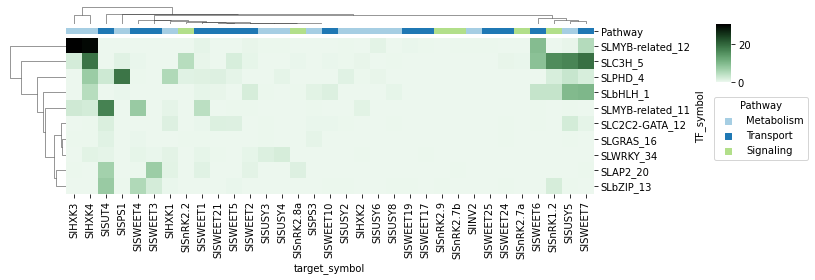

In [18]:
#fig, ax = plt.subplots(1,1, figsize=(7,6))
import matplotlib.colors as colors


plt.rcParams["figure.figsize"] = [8, 8.2]
plt.rcParams["figure.autolayout"] = True

h = sns.clustermap(Suc_known_gene_regulon_mat, figsize=(10, 4), 
                   cmap=sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True),
               dendrogram_ratio=0.1,
               cbar_pos=(1, 0.7, 0.02, 0.2),
               col_colors=col_color[['Pathway']], 
               #norm=colors.CenteredNorm(vcenter=0, halfrange=None, clip=False)
              )
"""
ax = plt.gca()

for i, row in TF_cols.iterrows():
    ax.scatter(None,None, label=row['TFFs'], color=row['color'])

ax.legend(loc=5)

ax.margins(0.15)
plt.axis("off")
plt.tight_layout()
"""

ax = plt.gca()
for i, row in col_color.drop_duplicates().iterrows():
    ax.scatter(None,None, color=row['Pathway'], label=row['Gene function'], marker='s')

ax.legend(loc="right", title='Pathway', bbox_to_anchor=(6.7, -0.8), ncol=1)
#h.add_legend()
#plt.tight_layout()

h.savefig("Suc_related_gene_TF_regulon_module_importance.pdf")


/Users/yuanzan/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 1.0)

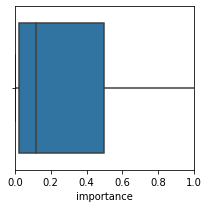

In [20]:
plt.rcParams["figure.figsize"] = [3, 3]
ax = sns.boxplot(Suc_known_gene_regulon['importance'])
ax.set_xlim(0, 1)

In [21]:
def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = np.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    # Create hierarchical cluster
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership = list(hierarchy.fcluster(Z, t=1.15))
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())


def subG(df):
    G = nx.Graph()
    G.clear()
    nodes = list(set(pd.concat([df["TF"], df["target"]], axis=0)))
    subG = nx.Graph()
    
    for i in nodes:
        G.add_node(i)
    for i,row in df.iterrows():
        G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])
    return G

def network_G_pos(grn_sub):
    G = nx.Graph()
    G.clear()

    U = nx.Graph()
    U.clear()

    TF_t = grn_sub[["TF", 'TF_type']]
    TF_t.columns = ['node', 'type']
    
    target_t = grn_sub[["target", 'target_type']]
    target_t.columns = ['node', 'type']

    nodes = pd.concat([TF_t, target_t], axis=0).drop_duplicates(keep='first')
    
    for i, row in nodes.iterrows():
        G.add_node(row['node'])

    for i, row in grn_sub.iterrows():
        G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])


    for i in grn_sub["TF"].unique():
        subdf = grn_sub[grn_sub["TF"]==i]
        sG = subG(subdf)
        U = nx.disjoint_union(U, sG)
        #break

    #### draw graph ####
    plt.figure(1, figsize=(8, 6))
    # layout graphs with positions using graphviz neato

    H = G.subgraph(next(nx.connected_components(G)))
    # Makes life easier to have consecutively labeled integer nodes
    H = nx.convert_node_labels_to_integers(H)
    # Create parititions with hierarchical clustering
    partitions = create_hc(H)
    # Build blockmodel graph
    BM = nx.quotient_graph(H, partitions, relabel=True)

    return nodes, U, G, H
    
    
#nodes, U, G, H = network_G_pos(Suc_TFs_modules)


def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = np.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    # Create hierarchical cluster
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership = list(hierarchy.fcluster(Z, t=1.15))
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())


def subG(df):
    G = nx.Graph()
    G.clear()
    nodes = list(set(pd.concat([df["TF"], df["target"]], axis=0)))
    subG = nx.Graph()
    
    for i in nodes:
        G.add_node(i)
    for i,row in df.iterrows():
        G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])
    return G



In [22]:
def network_G_pos2(grn_sub):
    G = nx.Graph()
    G.clear()

    #TF_t = grn_sub[["TF", 'TF_type']]
    TF_t = grn_sub[["TF_symbol", 'TF_type']]
    TF_t.columns = ['node', 'type']
    
    target_t = grn_sub[["target", 'target_type']]
    target_t.columns = ['node', 'type']

    nodes = pd.concat([TF_t, target_t], axis=0).drop_duplicates(keep='first')
    nodes.index = range(nodes.shape[0])
    
    for i, row in nodes.iterrows():
        G.add_node(row['node'])

    for i, row in grn_sub.iterrows():
        #G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])
        G.add_edge(row['TF_symbol'], row['target'], length=row['importance'], weight=row['importance'])

    """
    H = G.subgraph(next(nx.connected_components(G)))
    H = nx.convert_node_labels_to_integers(H)
    # Create parititions with hierarchical clustering
    partitions = create_hc(H)
    # Build blockmodel graph
    BM = nx.quotient_graph(H, partitions, relabel=True)
    """
    return nodes, G

    
    
nodes, G = network_G_pos2(Suc_TFs_modules)


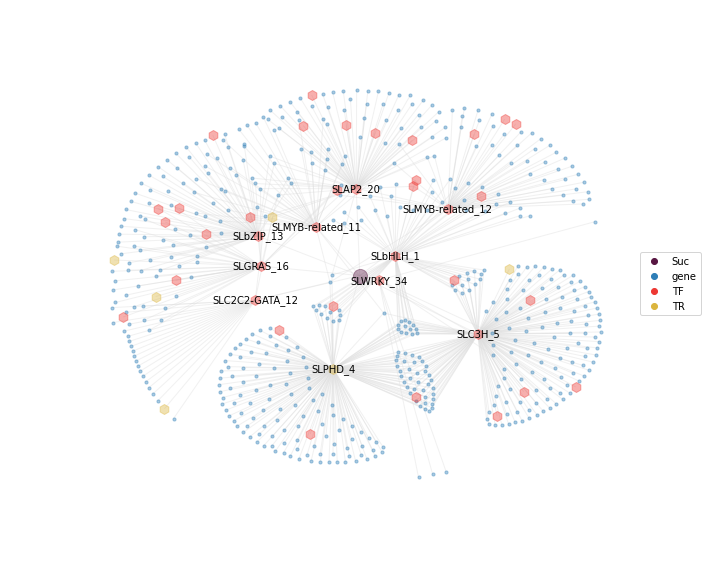

In [23]:
grnboost_sub = Suc_TFs_modules
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")


plt.figure(1, figsize=(10, 8))

def plot_target_node(GG, poss, nodeDF, nodetype="gene", nodecolor="#2E7EB7", node_size=20, alpha=0.4):
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['node'].to_list()
    #nodelist = nodeDF.index
    nodes_s = nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_size=node_size, node_color=nodecolor, alpha=alpha)
    
def plot_TF_node(GG, poss, nodeDF, nodetype="gene", nodecolor="#2E7EB7", node_size=20, alpha=0.4):
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['node'].to_list()
    #nodelist = nodeDF.index
    nodes_s = nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_shape = 'h', node_size=node_size, node_color=nodecolor, alpha=alpha)
    
    
nodes1 = plot_target_node(G, pos, nodes, nodetype="gene", nodecolor="#2E7EB7", node_size=10)
nodes2 = plot_target_node(G, pos, nodes, nodetype="sugar", nodecolor="#581642", node_size=200)
#nodes3 = plot_target_node(G, pos, nodes.query('type=="energy"'), nodetype="energy", nodecolor="#DBB53E", node_size=10)
nodes4 = plot_TF_node(G, pos, nodes, nodetype="TF", nodecolor="#ED3833", node_size=100)
nodes5 = plot_TF_node(G, pos, nodes, nodetype="TR", nodecolor="#DBB53E", node_size=100)
    
    
def plot_TF_node(GG, poss, grn_DF, nodeDF, nodetype="sugar", nodecolor="red", node_size=20, alpha=0.4):
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['node'].to_list()
    
    #target_count = pd.DataFrame(grn_DF.groupby(["TF"]).sum()['cc'])
    target_count = pd.DataFrame(grn_DF.groupby(["TF_symbol"]).sum()['cc'])
    aa = nodeDF.index.isin(target_count.index)==False
    notIntarget_count = nodeDF.index[aa].to_list()
    
    notIntarget_count = pd.DataFrame({'cc':[1]*len(notIntarget_count)}, index=notIntarget_count)
    target_count = target_count.append(notIntarget_count)
    
    #target_count.loc[notIntarget_count, 'cc'] = [1]
    #print(target_count)
    
    node_size = node_size * target_count.loc[nodeDF.index, 'cc']/6
    nodes_s = nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_size=node_size, 
                                     node_color=nodecolor, 
                                     #label=nodeDF.index.to_list(), 
                                     alpha=alpha)
    
#nodes6 = plot_TF_node(H, pos, grnboost_sub, nodes.query('type=="TF" or type=="TR"'), nodetype="TF/TR", nodecolor="#581642", node_size=20)
#nodes7 = plot_TF_node(H, pos, grnboost_sub, nodes_df, nodetype="energy", nodecolor="#DBB53E", node_size=20)

"""
top7TFs = grnboost_sub[['TF', 'targetN']].sort_values(['targetN'], ascending=False).drop_duplicates().head(10)['TF'].to_list()
top7TFs = nodes_df.loc[top7TFs,:]

bbox={'facecolor': 'w', #填充色
      'edgecolor': 'None',#外框色
      'alpha': 0.5, #框透明度
      'pad': 2,#本文与框周围距离
     }

nx.draw_networkx_labels(H, pos, labels={row['range']:i for i,row in top7TFs.iterrows()}, 
                        font_size=10, 
                        font_family="sans-serif", 
                        font_color='k',
                        bbox=bbox
                        )


"""

nx.draw_networkx_labels(G, pos, labels={i:i for i in grnboost_sub["TF_symbol"].unique()}, 
                        font_size=10, 
                        font_family="sans-serif", 
                        font_color='k',
                        #bbox=bbox
                        )


edge_colors = range(int(grnboost_sub['importance'].min()), int(grnboost_sub['importance'].max()))


cmap = plt.cm.plasma


# edge_color="gainsboro", 
edges = nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="gainsboro")

ax = plt.gca()
ax.scatter(None,None, label='Suc', color='#581642')
#ax.scatter(None,None, label='energy', color='#DBB53E')
ax.scatter(None,None, label='gene', color='#2E7EB7')
ax.scatter(None,None, label='TF', color='#ED3833')
ax.scatter(None,None, label='TR', color='#DBB53E')
ax.legend(loc=5)
ax.margins(0.15)
plt.axis("off")
plt.tight_layout()


#ax.set_axis_off()
#plt.show()
plt.savefig("Suc_related_regulon.pdf")


In [230]:
#Suc_TFs_modules.to_csv("Suc_TFs_modules_20230314.csv", index=False)

In [24]:
Suc_known_gene_regulon2plot = Suc_known_gene_regulon.query('importance>0.1')

In [25]:
def network_G_pos3(grn_sub):
    G = nx.Graph()
    G.clear()
    
    TF_t = grn_sub[["TF_symbol", 'TF_type']]
    TF_t.columns = ['node', 'type']
    
    target_t = grn_sub[["target_symbol", 'target_group']]
    target_t.columns = ['node', 'type']
    
    nodes = pd.concat([TF_t, target_t], axis=0).drop_duplicates(keep='first')
    nodes.index = range(nodes.shape[0])
    #print(nodes)
    for i in nodes:
        G.add_node(i)

    for i, row in grn_sub.iterrows():
        #G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])
        G.add_edge(row['TF_symbol'], row['target_symbol'], length=row['importance'], weight=row['importance'])

    return nodes, G

nodes2, G2 = network_G_pos3(Suc_known_gene_regulon2plot)


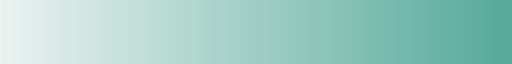

In [26]:
sns.color_palette("light:#5A9", as_cmap=True)

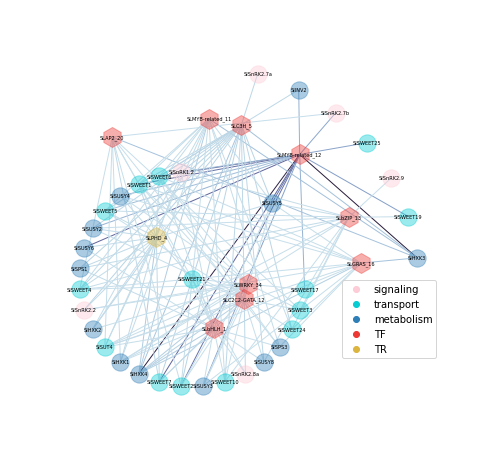

In [31]:
pos2 = nx.nx_agraph.graphviz_layout(G2, prog="twopi")


plt.figure(1, figsize=(7, 6.5))

def plot_target_node2(GG, poss, nodeDF, nodetype="gene", nodecolor="#2E7EB7", node_size=20, alpha=0.4):
    #print(nodeDF).shape
    #nodeDF = nodeDF.copy()
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['node'].to_list()
    #nodelist = nodeDF.index
    nodes_s = nx.draw_networkx_nodes(GG, poss, nodelist=nodelist, node_size=node_size, node_color=nodecolor, alpha=alpha)
    
def plot_TF_node2(GG, poss, nodeDF, nodetype="gene", nodecolor="#2E7EB7", node_size=20, alpha=0.4):
    #print(nodeDF).shape
    #nodeDF = nodeDF.copy()
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['node'].to_list()
    #nodelist = nodeDF.index
    nodes_s = nx.draw_networkx_nodes(GG, poss, nodelist=nodelist, node_shape = 'h',
                                     node_size=node_size, node_color=nodecolor, alpha=alpha)
    
nodes_1 = plot_TF_node2(G2, pos2, nodes2, nodetype="TF", nodecolor="#ED3833", node_size=400)
nodes_2 = plot_TF_node2(G2, pos2, nodes2, nodetype="TR", nodecolor="#DBB53E", node_size=400)

nodes_3 = plot_target_node2(G2, pos2, nodes2, nodetype="metabolism", nodecolor="#2E7EB7", node_size=300)
nodes_4 = plot_target_node2(G2, pos2, nodes2, nodetype="transport", nodecolor="#07CCD2", node_size=300)
nodes_5 = plot_target_node2(G2, pos2, nodes2, nodetype="signaling", nodecolor="#FDCCD6", node_size=300)

    

nx.draw_networkx_labels(G2, pos2, labels={i:i for i in nodes2["node"].unique()}, 
                        font_size=5, 
                        font_family="sans-serif", 
                        font_color='k',
                        #bbox=bbox
                        )


edge_colors = range(int(Suc_known_gene_regulon2plot['importance'].min()), int(Suc_known_gene_regulon2plot['importance'].max()))


cmap = plt.cm.plasma


# edge_color="gainsboro", 
#edges2 = nx.draw_networkx_edges(G2, pos2, alpha=0.4, edge_color="gainsboro")

#nx.draw_networkx_edges(G2, pos2, alpha=0.4, edge_color=cmap)
edge_colors = Suc_known_gene_regulon2plot['importance']

cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
#sns.color_palette("light:#5A9", as_cmap=True)
#plt.cm.Blues
options = {
    "edge_color": edge_colors,
    "width": 1,
    "edge_cmap": cmap,
}

edges = nx.draw_networkx_edges(G2, pos2, **options)
"""
pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)

ax = plt.gca()
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
"""


ax = plt.gca()


ax.scatter(None,None, label='signaling', color='#FDCCD6')
ax.scatter(None,None, label='transport', color='#07CCD2')
ax.scatter(None,None, label='metabolism', color='#2E7EB7')
ax.scatter(None,None, label='TF', color='#ED3833')
ax.scatter(None,None, label='TR', color='#DBB53E')
#ax.legend(loc=5)
ax.legend(loc="right", title='', bbox_to_anchor=(0.9, 0.3), ncol=1)

ax.margins(0.15)
plt.axis("off")
plt.tight_layout()

#ax.set_axis_off()
#plt.show()
plt.savefig("Suc_related_gene_TF_regulon_module_importance_network.pdf")


## regulon heatmap

In [184]:
Suc_known_gene_regulon2plot

,TF,target,importance,TF_type,target_type,target_group,target_symbol,meta_group,TF_symbol
7365,Solyc07g026680.2,Solyc12g008510.2,30.169215,TF,gene,metabolism,SlHXK3,metabolism,SLMYB-related_12
8121,Solyc07g026680.2,Solyc04g081400.3,29.338428,TF,gene,metabolism,SlHXK4,metabolism,SLMYB-related_12
25753,Solyc02g082110.4,Solyc04g064630.3,18.921355,TF,gene,transport,SlSWEET7,transport,SLC3H_5
27260,Solyc02g082110.4,Solyc04g081400.3,18.414346,TF,gene,metabolism,SlHXK4,metabolism,SLC3H_5
27497,Solyc05g042030.3,Solyc08g042000.3,18.332312,TR,gene,metabolism,SlSPS1,metabolism,SLPHD_4
...,...,...,...,...,...,...,...,...,...
2007721,Solyc01g059950.1,Solyc03g121070.3,0.108084,TF,gene,metabolism,SlHXK1,metabolism,SLGRAS_16
2024254,Solyc07g026680.2,Solyc03g115700.3,0.106125,TF,gene,signaling,SlSnRK1.2,signaling,SLMYB-related_12
2046807,Solyc12g008830.3,Solyc02g071520.3,0.103508,TF,gene,transport,SlSWEET3,transport,SLC2C2-GATA_12
2064462,Solyc07g026680.2,Solyc03g097600.3,0.101504,TF,gene,transport,SlSWEET5,transport,SLMYB-related_12


In [212]:
suc_tfs1 = pd.DataFrame(Suc_known_gene_regulon2plot[['TF', 'TF_symbol']])
suc_tfs1.columns = ['gene', 'symbol']
suc_target1 = pd.DataFrame(Suc_known_gene_regulon2plot[['target', 'target_symbol']])
suc_target1.columns = ['gene', 'symbol']

suc_tf_targets = pd.concat([suc_tfs1, suc_target1]).drop_duplicates().reset_index()
suc_tf_targets.loc[-1, :] = [11, "Suc", "Suc"]
suc_tf_targets.index = suc_tf_targets['gene']

In [220]:
suc_tf_targets_genes = suc_tf_targets['gene'].to_list()
#suc_tf_targets_genes.append('Suc')

suc_tf_targets_genes_EXP = adata.to_df().loc[:, suc_tf_targets_genes]
suc_tf_targets_genes_EXP.columns = suc_tf_targets.loc[suc_tf_targets_genes_EXP.columns, "symbol"].to_list()
suc_tf_targets_genes_EXP = suc_tf_targets_genes_EXP.T


In [238]:
adata.obs['sample'] = adata.obs.index
adata.obs['conditon_HAG'] = adata.obs['sample'].str.split("h-", expand=True)[0]
adata.obs['conditon'] = adata.obs['conditon_HAG'].str.split("[0-9]", expand=True)[0]
adata.obs['HAG'] = adata.obs['conditon_HAG'].str.lstrip('CD').astype(int)
adata.obs.head(2)

,sample,conditon_HAG,HAG,conditon
sample,,,,
CD0h-1,CD0h-1,CD0,0,CD
CD0h-2,CD0h-2,CD0,0,CD


In [255]:
p_df_meta1 = pd.concat([adata.obs.query('conditon=="C"'), 
           adata.obs.query('conditon=="D"'), 
           adata.obs.query('conditon=="CC"'), 
           adata.obs.query('conditon=="DD"'), 
           adata.obs.query('conditon=="CD"')], axis=0)

In [263]:
p1_df = pd.concat([suc_tf_targets_genes_EXP.T.loc[p_df_meta1.index, :], p_df_meta1[["conditon_HAG"]]], axis=1).groupby(['conditon_HAG']).mean()
p1_df = p1_df.loc[p_df_meta1[['conditon_HAG']].drop_duplicates()['conditon_HAG'],:]

In [277]:
import os
os.getcwd()

'/Users/yuanzan/Documents/github/seqyuan/tomato_graft_omics/notebooks/GRN'

/Users/yuanzan/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:65: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.figure.savefig(*args, **kwargs)


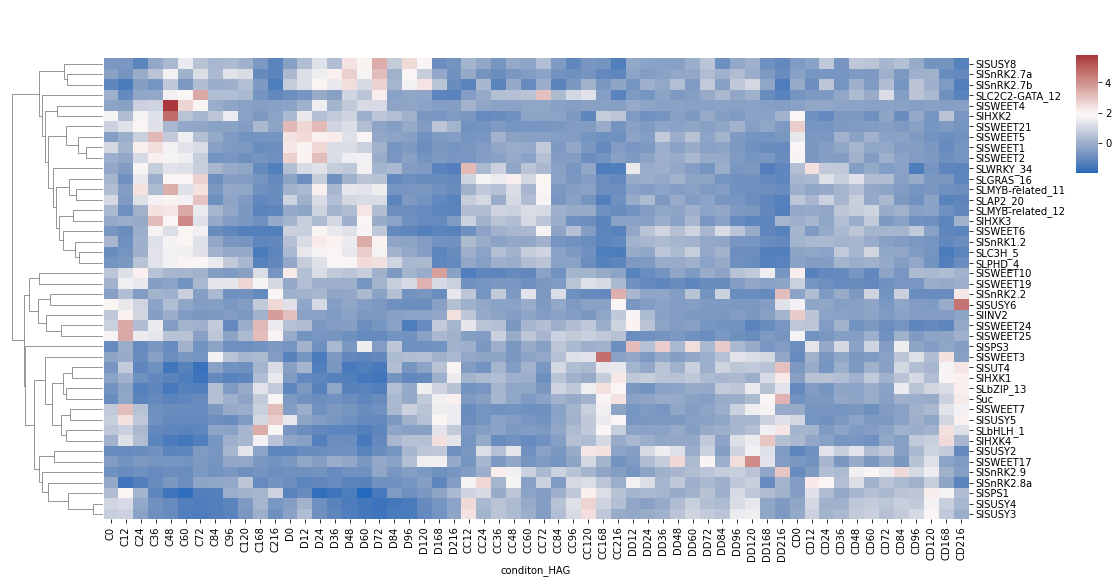

In [275]:
#fig, ax = plt.subplots(1,1, figsize=(7,6))
import matplotlib.colors as colors


#plt.rcParams["figure.figsize"] = [8, 8.2]
plt.rcParams["figure.autolayout"] = True

h = sns.clustermap(p1_df.T, figsize=(15,8.2), cmap='vlag',
               dendrogram_ratio=0.1, col_cluster=False,
               cbar_pos=(1, 0.7, 0.02, 0.2), z_score=0,
               #col_colors=homo_metadata_31[['Class']], 
               #norm=colors.CenteredNorm(vcenter=0, halfrange=None, clip=False)
              )

"""
ax = plt.gca()
for i, row in homo_metadata_31.drop_duplicates().iterrows():
    ax.scatter(None,None, color=row['Class'], label=row['class_origin'], marker='s')

ax.legend(loc="right", title='Class', bbox_to_anchor=(5, -0.8), ncol=1)
#h.add_legend()
#plt.tight_layout()
"""
h.savefig("suc_genes_exp.pdf")

# CoA

In [332]:
coa_related_genes = """Solyc01g059880.3
Solyc01g073740.4
Solyc01g101040.3
Solyc04g039670.3
Solyc05g005160.3
Solyc07g055840.3
Solyc12g011000.2
Solyc12g099260.2""".split("\n")

In [334]:
_TFs = grnboost.query('target=="Acetyl-CoA" and importance>=7')
print(_TFs.shape)

_TFs_modules = grnboost[grnboost["TF"].isin(_TFs['TF'])].query('target!="Acetyl-CoA"')
_TFs_modules = _TFs_modules.query('importance>=3')
print(_TFs_modules.shape)

_TFs_modules = _TFs_modules[_TFs_modules['target'].isin(coa_related_genes)]

print(_TFs_modules.shape)

(8, 3)
(4920, 3)
(9, 3)


In [343]:
_TFs_modules_genes = _TFs_modules[['target']].drop_duplicates()['target'].to_list()
_TFs_modules_genes.append('Solyc02g082110.4')
_TFs_modules_genes.append('Acetyl-CoA')
_TFs_modules_genes_EXP = adata.to_df().loc[:, _TFs_modules_genes]


In [344]:
p_coa_df = pd.concat([_TFs_modules_genes_EXP.loc[p_df_meta1.index, :], p_df_meta1[["conditon_HAG"]]], axis=1).groupby(['conditon_HAG']).mean()
p_coa_df = p_coa_df.loc[p_df_meta1[['conditon_HAG']].drop_duplicates()['conditon_HAG'],:]

/Users/yuanzan/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:65: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.figure.savefig(*args, **kwargs)
/Users/yuanzan/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  func(*args, **kwargs)
/Users/yuanzan/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


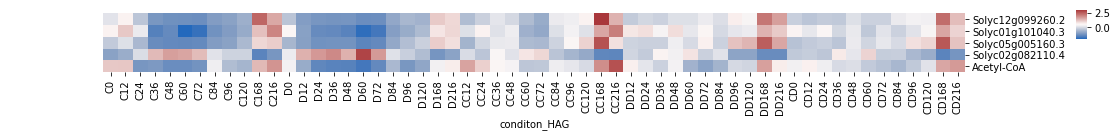

In [345]:
import matplotlib.colors as colors

plt.rcParams["figure.autolayout"] = True

h = sns.clustermap(p_coa_df.T, figsize=(15, 2), cmap='vlag',
               dendrogram_ratio=0.1, col_cluster=False, row_cluster=False,
               cbar_pos=(1, 0.7, 0.01, 0.2), z_score=0,
               #col_colors=homo_metadata_31[['Class']], 
               #norm=colors.CenteredNorm(vcenter=0, halfrange=None, clip=False)
              )
h.savefig("CoA_genes_exp.pdf")

### network

In [99]:
CoA_TFs = grnboost.query('target=="Acetyl-CoA" and importance>=7')
print(CoA_TFs.shape)

CoA_TFs_modules = grnboost[grnboost["TF"].isin(CoA_TFs['TF'])].query('target!="Acetyl-CoA"')
CoA_TFs_modules = CoA_TFs_modules.query('importance>=3')
print(CoA_TFs_modules.shape)
CoA_TFs_modules = pd.concat([CoA_TFs_modules, CoA_TFs], axis=0)

CoA_TFs_modules["TF_type"] = adata.var.loc[CoA_TFs_modules["TF"], "type"].to_list()
CoA_TFs_modules["target_type"] = adata.var.loc[CoA_TFs_modules["target"], "type"].to_list()
#CoA_TFs_modules = CoA_TFs_modules.query('target_type!="energy"') 

#CoA_TFs_modules.head(2)

(8, 3)
(4920, 3)


In [100]:
CoA_TFs_modules['TF_symbol'] = None
CoA_TFs_modules["TF_symbol"] = gene_TF_type2.loc[CoA_TFs_modules["TF"].to_list(), "TF-Family2"].to_list()

In [101]:
#CoA_TFs_modules.query('importance > 20')
CoA_TFs_modules = CoA_TFs_modules.query('importance>=30 or target=="Acetyl-CoA"')
print(CoA_TFs_modules.shape)

CoA_TFs_modules.loc[CoA_TFs_modules[CoA_TFs_modules['target_type']=="energy"].index, "target_type"] = "Acetyl-CoA"

CoA_TFs_modules.head(2)


(192, 6)


,TF,target,importance,TF_type,target_type,TF_symbol
12,Solyc02g082110.4,Solyc01g110290.3,73.238874,TF,gene,SLC3H_5
24,Solyc02g082110.4,Solyc09g074100.4,68.823340,TF,gene,SLC3H_5


In [134]:
CoA_TFs_modules.to_csv("CoA_TFs_modules_20230316.csv")

In [102]:
nodes_CoA, G_CoA = network_G_pos2(CoA_TFs_modules)

In [125]:
pos_CoA = nx.nx_agraph.graphviz_layout(G_CoA, prog="twopi")

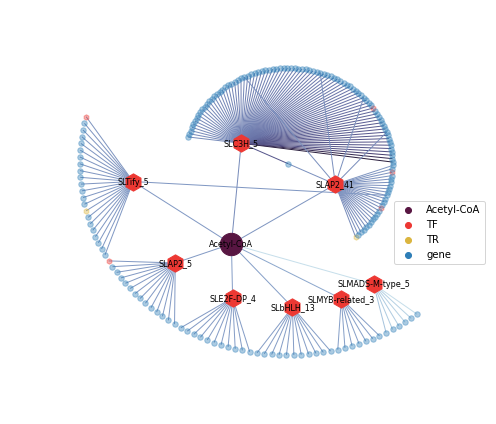

In [133]:
plt.figure(1, figsize=(7, 6))

def plot_target_node2(GG, poss, nodeDF, nodetype="gene", nodecolor="#2E7EB7", node_size=20, alpha=0.4):
    #print(nodeDF).shape
    #nodeDF = nodeDF.copy()
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['node'].to_list()
    #nodelist = nodeDF.index
    nodes_s = nx.draw_networkx_nodes(GG, poss, nodelist=nodelist, node_size=node_size, node_color=nodecolor, alpha=alpha)
    
def plot_TF_node2(GG, poss, nodeDF, nodetype="gene", nodecolor="#2E7EB7", node_size=20, alpha=0.4):
    #print(nodeDF).shape
    #nodeDF = nodeDF.copy()
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['node'].to_list()
    #nodelist = nodeDF.index
    nodes_s = nx.draw_networkx_nodes(GG, poss, nodelist=nodelist, node_shape = 'h',
                                     node_size=node_size, node_color=nodecolor, alpha=alpha)
    
nodes_1 = plot_TF_node2(G_CoA, pos_CoA, nodes_CoA, nodetype="TF", nodecolor="#ED3833", node_size=30)
nodes_2 = plot_TF_node2(G_CoA, pos_CoA, nodes_CoA, nodetype="TR", nodecolor="#DBB53E", node_size=30)

nodes3 = plot_target_node2(G_CoA, pos_CoA, nodes_CoA, nodetype="gene", nodecolor="#2E7EB7", node_size=30)

nodes4 = plot_target_node2(G_CoA, pos_CoA, nodes_CoA, nodetype="Acetyl-CoA", nodecolor="#581642", node_size=500, alpha=1)

TF_genes = gene_TF_type2.loc[CoA_TFs["TF"].to_list(), "TF-Family2"].to_list()

TFs = nx.draw_networkx_nodes(G_CoA, pos_CoA, nodelist=TF_genes, node_shape = 'h',
                                     node_size=300, node_color='#ED3833', alpha=1)
    
    



nx.draw_networkx_labels(G_CoA, pos_CoA, labels={i:i for i in TF_genes}, 
                        font_size=8, 
                        font_family="sans-serif", 
                        font_color='k',
                        #bbox=bbox
                        )
nx.draw_networkx_labels(G_CoA, pos_CoA, labels={"Acetyl-CoA": "Acetyl-CoA"}, 
                        font_size=8, 
                        font_family="sans-serif", 
                        font_color='k',
                        #bbox=bbox
                        )

#cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
#sns.color_palette("light:#5A9", as_cmap=True)
#plt.cm.Blues

edge_colors = CoA_TFs_modules['importance']

cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
options = {
    "edge_color": edge_colors,
    "width": 1,
    "edge_cmap": cmap,
}

edges = nx.draw_networkx_edges(G_CoA, pos_CoA, **options)

ax = plt.gca()

ax.scatter(None,None, label='Acetyl-CoA', color='#581642')
ax.scatter(None,None, label='TF', color='#ED3833')
ax.scatter(None,None, label='TR', color='#DBB53E')
ax.scatter(None,None, label='gene', color='#2E7EB7')

#ax.legend(loc=5)
ax.legend(loc="right", title='', bbox_to_anchor=(1, 0.45), ncol=1)

ax.margins(0.15)
plt.axis("off")
plt.tight_layout()

#ax.set_axis_off()
#plt.show()
plt.savefig("Acetyl-CoA_related_gene_TF_regulon_module_importance_network.pdf")


In [85]:
edge_colors

12       73.238874
24       68.823340
105      61.024120
238      55.667554
323      53.798785
           ...    
38449    15.234534
48596    13.095217
49595    12.906214
82303     8.633197
85580     8.322737
Name: importance, Length: 579, dtype: float64

In [52]:
CoA_genes = pd.read_table("Acetyl-CoA_genes.txt", index_col=0)
CoA_genes.head(2)

,symbol
ID,
Solyc02g094640.4,SlACS1
Solyc07g017860.3,SlACS2


In [58]:
CoA_genes.index[CoA_genes.index.isin(grnboost['target'])]

Index(['Solyc05g024160.3'], dtype='object', name='ID')

In [59]:
grnboost[grnboost['target'].isin(CoA_genes.index)]

,TF,target,importance
15060,Solyc03g123430.4,Solyc05g024160.3,23.900486
28454,Solyc03g111260.3,Solyc05g024160.3,18.029049
33600,Solyc06g053960.3,Solyc05g024160.3,16.465147
36744,Solyc02g093590.3,Solyc05g024160.3,15.651089
43705,Solyc06g069430.3,Solyc05g024160.3,14.058262
...,...,...,...
4610196,Solyc05g052410.3,Solyc05g024160.3,0.000378
4631663,Solyc02g077590.1,Solyc05g024160.3,0.000202
4650205,Solyc02g067800.4,Solyc05g024160.3,0.000071
4651625,Solyc02g071220.3,Solyc05g024160.3,0.000062


# regulon go function plot

In [161]:
SUC_regulon_GO = pd.read_csv("SUC_regulon_GO.csv")
SUC_regulon_GO['TF_regulon'] = gene_TF_type2.loc[SUC_regulon_GO['TF'], "TF-Family2"].to_list()
SUC_regulon_GO = SUC_regulon_GO.sort_values(['TF_regulon', 'pvalue'], ascending=True)
SUC_regulon_GO['-log(pvalue)'] = -np.log(SUC_regulon_GO['pvalue'])

In [281]:
SUC_regulon_GO['TF_regulon'].unique()

array(['SLAP2_41', 'SLC3H_5', 'SLTify_5'], dtype=object)

In [279]:
TF = "SLbHLH_1"
ax = sns.barplot(data=SUC_regulon_GO.query('TF_regulon=="{0}"'.format(TF)).head(10), 
            x="-log(pvalue)", y="Description", color="b", alpha=0.4
           )
ax.set_ylabel("")
ax.set_title(TF)


ValueError: min() arg is an empty sequence

# ATP module

In [285]:
atp_genes = """Solyc03g115110.4
Solyc04g007550.4
Solyc04g072047.1
Solyc05g008460.4
Solyc05g050500.1
Solyc05g052140.3
Solyc05g052150.4
Solyc06g005010.1
Solyc06g005020.3
Solyc06g009920.2
Solyc06g048430.4
Solyc06g063220.3
Solyc06g065990.1
Solyc06g066000.3
Solyc11g063573.1
Solyc11g072450.2
Solyc12g005060.1
Solyc12g006210.1
Solyc12g010870.3
Solyc12g055760.2
Solyc12g056830.1""".split("\n")

In [322]:
ATP_TFs = grnboost.query('target=="ATP" and importance>=6')
ATP_TFs_modules = grnboost[grnboost["TF"].isin(ATP_TFs['TF'])].query('target!="ATP"')
ATP_TFs_modules = ATP_TFs_modules.query('importance>=2')

ATP_TFs_modules = ATP_TFs_modules[ATP_TFs_modules['target'].isin(atp_genes)]

print(ATP_TFs_modules.shape)

(12, 3)


In [324]:
ATP_TFs_modules_genes = ATP_TFs_modules[['target']].drop_duplicates()['target'].to_list()
ATP_TFs_modules_genes.append('ATP')
ATP_TFs_modules_genes_EXP = adata.to_df().loc[:, ATP_TFs_modules_genes]


In [325]:
p_atp_df = pd.concat([ATP_TFs_modules_genes_EXP.loc[p_df_meta1.index, :], p_df_meta1[["conditon_HAG"]]], axis=1).groupby(['conditon_HAG']).mean()
p_atp_df = p_atp_df.loc[p_df_meta1[['conditon_HAG']].drop_duplicates()['conditon_HAG'],:]

/Users/yuanzan/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:65: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.figure.savefig(*args, **kwargs)


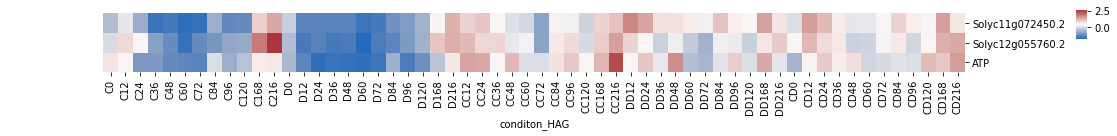

In [331]:
import matplotlib.colors as colors

plt.rcParams["figure.autolayout"] = True

h = sns.clustermap(p_atp_df.T, figsize=(15, 2), cmap='vlag',
               dendrogram_ratio=0.1, col_cluster=False, row_cluster=False,
               cbar_pos=(1, 0.7, 0.01, 0.2), z_score=0,
               #col_colors=homo_metadata_31[['Class']], 
               #norm=colors.CenteredNorm(vcenter=0, halfrange=None, clip=False)
              )
h.savefig("ATP_genes_exp.pdf")